# $\fbox{4-5}$ 予測精度の評価 ~ 予実比較

## $\chi^2$ 検定

In [1]:
%matplotlib notebook

import gc
import math
import pickle

# 本書 4 章の関数群を含む自作ライブラリ
import mylibs.mylib4 as mylib4

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

pd.options.display.max_rows = 6
pd.options.display.max_columns = 12

In [2]:
from scipy import stats

print('p-value:', 1 - stats.chi2.cdf(1, 1))

p-value: 0.31731050786291415


In [3]:
print('95 percentile:', stats.chi2.ppf(0.95, 1))

95 percentile: 3.841458820694124


### 公式の導出

### 自由度に関する目安


<IPython.core.display.Javascript object>


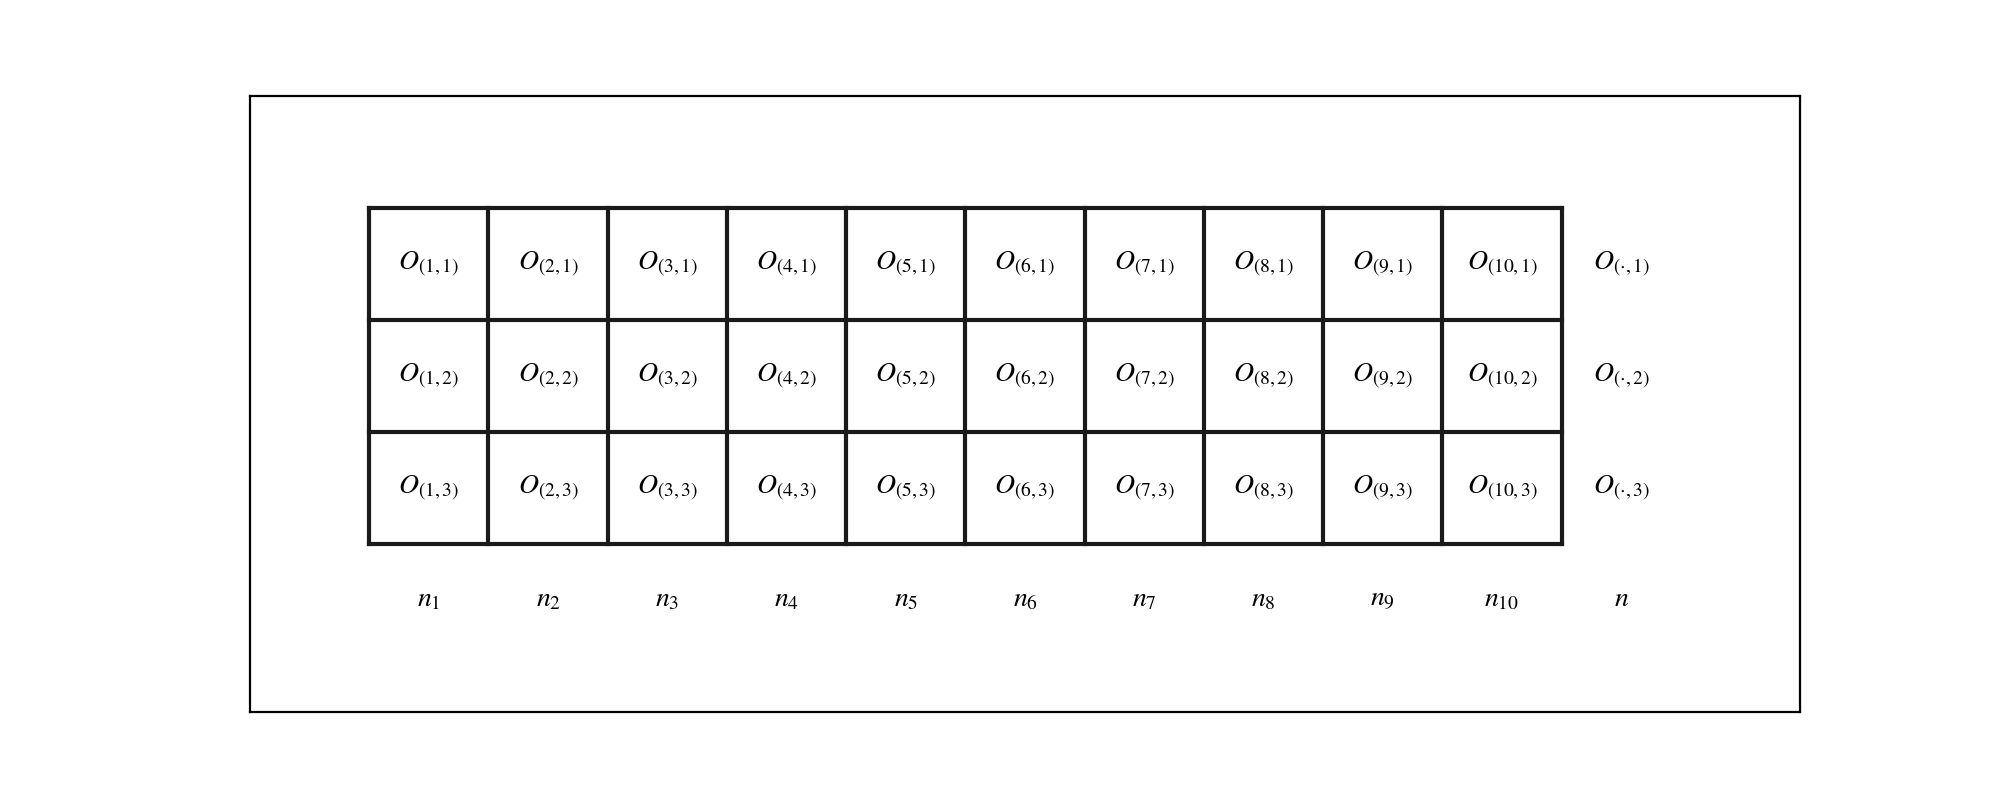

In [4]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
ax.set_xlim([-1, 12])
ax.set_ylim([-1.5, 4])
plt.xticks(color='None')
plt.yticks(color='None')
plt.tick_params(color='None') 
# 横線
X = [0, 10]
for y in np.arange(4):
    Y = [y, y]
    ax.plot(X, Y, c='k')
# 縦線
Y = [0, 3]
for x in np.arange(11):
    X = [x, x]
    ax.plot(X, Y, c='k')
# セル内数式
for x in np.arange(10):
    for y in np.arange(3):
        f = r'$O_{(' + str(x+1) + ',' + str(3-y) + ')}$'
        ax.text(x+0.5, y+0.5, f, va='center', ha='center')
# 右側数式
ax.text(10.5, 2.5, r'$O_{(\cdot,1)}$', va='center', ha='center')
ax.text(10.5, 1.5, r'$O_{(\cdot,2)}$', va='center', ha='center')
ax.text(10.5, 0.5, r'$O_{(\cdot,3)}$', va='center', ha='center')
ax.text(10.5, -0.5, r'$n$', va='center', ha='center')
# 下側数式
for x in np.arange(10):
    f = r'$n_{' + str(x+1) + '}$'
    ax.text(x+0.5, -0.5, f, va='center', ha='center')

## ホスマー・レメショウ検定

## ホスマー・レメショウ検定の適用

In [5]:
(dict_bp, opt_result, df_summary) = mylib4.load_bases()
w = opt_result.x[0]

(y_actual, y_score) = mylib4.make_whole_actual_and_score(df_summary, dict_bp, w)

(y_actual, y_score)

(array([0., 0., 0., ..., 1., 1., 1.]),
 array([0.00769165, 0.00769165, 0.00769165, ..., 0.01358349, 0.01358349,
        0.01358349]))

In [6]:
df = pd.DataFrame(y_score, columns=['score'])
df['actual'] = y_actual
df = df.astype('f8')

df.head()

,score,actual
0,0.007692,0.0
1,0.007692,0.0
2,0.007692,0.0
3,0.007692,0.0
4,0.007692,0.0


In [7]:
q_bins = np.arange(11) / 10 # bins = [0, 0.1, 0.2, ... , 0.9, 1]
print(np.quantile(y_score, q_bins))

[0.         0.         0.00082993 0.00147623 0.0019613  0.00257815
 0.00340798 0.00460761 0.00697717 0.01327403 0.060776  ]


In [8]:
for m in np.arange(10)+1: # [1, 2, ... , 10]
    q_bins = np.arange(m + 1) / m
    bins = np.quantile(y_score, q_bins)
    print(m, bins[1])

1 0.060776002440328276
2 0.002578149475590748
3 0.0016539486779324668
4 0.0011443780827135644
5 0.0008299273601369041
6 0.0004550270522071458
7 0.0
8 0.0
9 0.0
10 0.0


In [9]:
m = 6
q_bins = np.arange(m + 1) / m
bins = np.quantile(y_score, q_bins)
group = pd.cut(df['score'], bins, labels=np.arange(m))
df['group'] = group

df

,score,actual,group
0,0.007692,0.0,4
1,0.007692,0.0,4
2,0.007692,0.0,4
...,...,...,...
138583,0.013583,1.0,5
138584,0.013583,1.0,5
138585,0.013583,1.0,5


In [10]:
# hl: Hosmer Lemeshow
df_hl = df.groupby(['group']).mean()
df_hl.columns = ['score_mean', 'actual_mean']

df_hl

,score_mean,actual_mean
group,,
0,0.000449,0.000000
1,0.001136,0.001190
2,0.002097,0.002011
3,0.003274,0.002887
4,0.005727,0.006265
5,0.017169,0.017069


In [11]:
df_hl['count'] = df.groupby(['group'])['score'].count()

df_hl

,score_mean,actual_mean,count
group,,,
0,0.000449,0.000000,1347
1,0.001136,0.001190,23525
2,0.002097,0.002011,22877
3,0.003274,0.002887,22862
4,0.005727,0.006265,23145
5,0.017169,0.017069,22966


In [12]:
df_hl[['score_sum', 'actual_sum']] = df.groupby(['group']).sum()

df_hl

,score_mean,actual_mean,count,score_sum,actual_sum
group,,,,,
0,0.000449,0.000000,1347,0.605257,0.0
1,0.001136,0.001190,23525,26.712945,28.0
2,0.002097,0.002011,22877,47.980542,46.0
3,0.003274,0.002887,22862,74.846862,66.0
4,0.005727,0.006265,23145,132.544868,145.0
5,0.017169,0.017069,22966,394.309525,392.0


In [13]:
df_hl['Tg'] = (df_hl['score_sum'] - df_hl['actual_sum'])**2 / \
              (df_hl['count'] * df_hl['score_mean'] * (1 - df_hl['score_mean']))

df_hl

,score_mean,actual_mean,count,score_sum,actual_sum,Tg
group,,,,,,
0,0.000449,0.000000,1347,0.605257,0.0,0.605529
1,0.001136,0.001190,23525,26.712945,28.0,0.062082
2,0.002097,0.002011,22877,47.980542,46.0,0.081925
3,0.003274,0.002887,22862,74.846862,66.0,1.049129
4,0.005727,0.006265,23145,132.544868,145.0,1.177140
5,0.017169,0.017069,22966,394.309525,392.0,0.013764


In [14]:
T = df_hl['Tg'].sum()
df = m - 2
print('T:', T)
print('df:', df)
print('95 percentile:', stats.chi2.ppf(0.95, df))
print('p-value:', 1 - stats.chi2.cdf(T, df))

T: 2.989568286671312
df: 4
95 percentile: 9.487729036781154
p-value: 0.5595726376944622


<IPython.core.display.Javascript object>


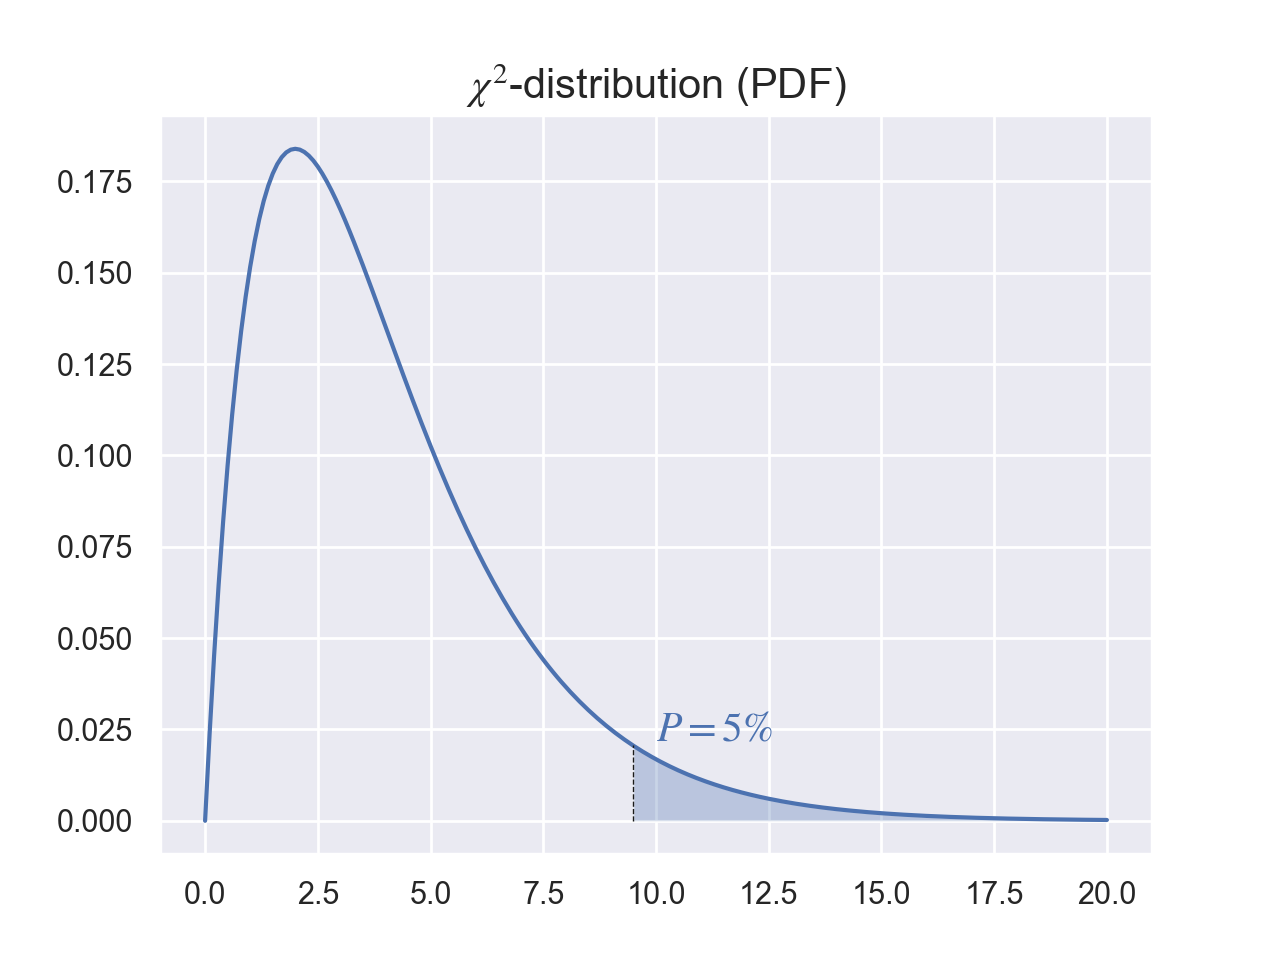

Text(0.5, 1.0, '$\\chi^2$-distribution (PDF)')

In [15]:
# カイ２乗分布（自由度4）のパーセント点の概念図

import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)
# 確率密度関数
x = np.linspace(0, 20, 201)
y = stats.chi2.pdf(x, 4)
plt.plot(x, y)
# 上側 5% 領域
x = np.arange(round(stats.chi2.ppf(0.95, 4)*100, 0), 2001) / \
    100  # [157.61, 157.62, ..., 199.99, 20]
y = stats.chi2.pdf(x, 4)
ax.fill_between(x, 0, y, facecolor='b', alpha=0.3)
# 点線
x = [stats.chi2.ppf(0.95, 4), stats.chi2.ppf(0.95, 4)]
y = [0, stats.chi2.pdf(x[0], 4)]
ax.plot(x, y, c='k', ls='--', lw=0.5)
# テキスト
t = r'$P=5\%$'
ax.text(10, 0.025, t,
        ha='left', va='center', color='b', fontsize=15)
ax.set_title(r'$\chi^2$' + '-distribution (PDF)', fontsize=15)

## QQ-プロット


<IPython.core.display.Javascript object>


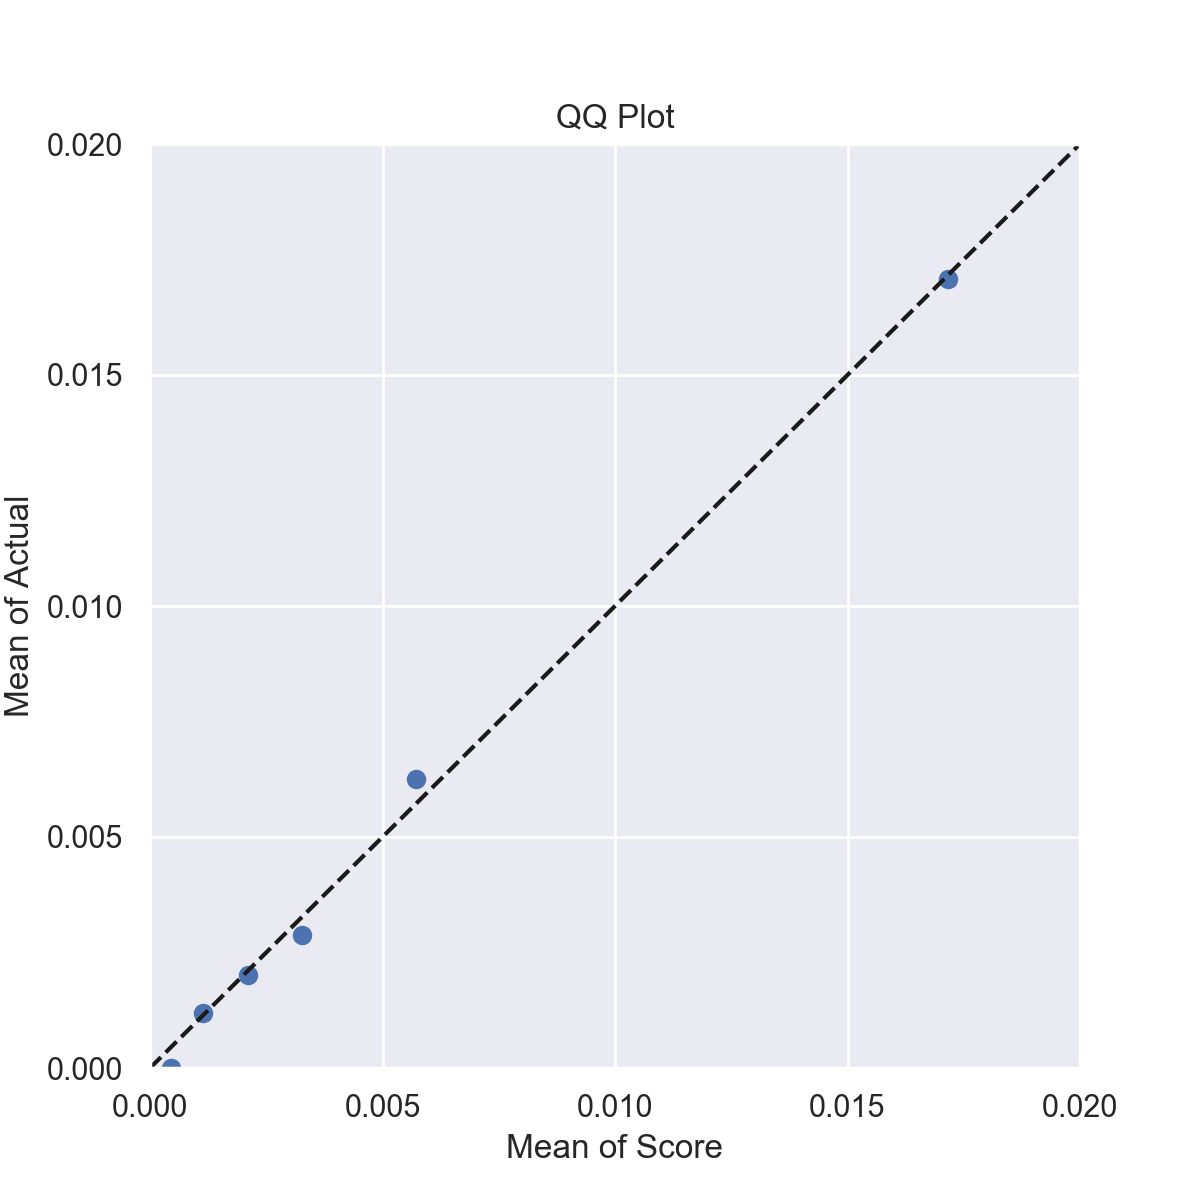

Text(0.5, 1.0, 'QQ Plot')

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(df_hl['score_mean'], df_hl['actual_mean'])
ax.plot([0, 0.02], [0, 0.02], c='k', ls='--')
ax.set_xlim([0, 0.02])
ax.set_ylim([0, 0.02])
major_ticks = [0, 0.005, 0.010, 0.015, 0.020]
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
ax.set_xlabel('Mean of Score')
ax.set_ylabel('Mean of Actual')
ax.set_title('QQ Plot')

## まとめ